# Introduction 

This Noteboos describes the Benchmark package Gird2Bench. The motivation for the development of Grid2Bench was initially to be able to benchmark L2RPN competition agents against the improvement reached by adding more complex action spaces. The objective of this package is to define certain criteria of agent evaluation with their corresponding visualization. The benchmarking platform Grid2Bench helps the power grid community to evaluate their operating agents and to compare their performances, which in turn helps in decision-making. 

In [1]:
import os
import sys

import kaleido
from grid2bench.AgentsAnalytics import AgentsAnalytics as aa
from grid2bench.AgentsAnalytics import AgentsAnalytics
from grid2bench.EpisodesDataTransformer import EpisodesDataTransformer as eps

import warnings
import ipywidgets as widgets
from ipywidgets import interact
from configmanager.configmanager import ConfigManager

warnings.filterwarnings("ignore")

Make sure you are adding the project root path on the sys.path varibale

In [2]:
if not os.path.abspath("..") in sys.path:
    sys.path.append(os.path.abspath(".."))

TOC
- [Results loading](#results_loading)
- [Cumulative reward](#cumulative_reward)
- [Actions frequency](#actions_frequency)
- [Impact of actions on objects](#actions_impact)
- [Action execution time](#execution_time)
- [Actions sequence length](#sequence_length)



# <a class="anchor" id="results_loading">Results loading</a>

### Loading params from the config file

We can load the config parameters by giving the path to the config file at the first place:

In [3]:
# config file name and path
conf_path = os.path.abspath("../conf.ini")
conf = ConfigManager(benchmark_name='Bench5', path=conf_path)

Once the config file is imported correctly, its parameters could be accessed easily as shown below: 

In [4]:
#Initialization of parameters for benchmarking 1
input_data_path = os.path.abspath(os.path.join('..', conf.get_option('data_path')))
agents_names = conf.get_option_tolist('agents_names')
episodes_names = conf.get_option_tolist('episodes_names')

### Loading all agents results using Agents_Analysis class

We can load all (or a list of selected agents) together in one command. It is important to notice that using this option, all the episodes of the agents are loaded. Due to potential memory problem, it is recommended that you load no more than two agents with all episodes on your local computer. 

In [5]:
agents = AgentsAnalytics(
    data_path=input_data_path,
    agents_names= agents_names,
    episodes_names= episodes_names)

100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


In [6]:
print(agents.agents_names)

['PPO_Agent', 'Tutor_binbinchen', 'Tutor N-1(200 Actions)_Tutor']


In [7]:
print(agents.episodes_names)

['jan32_1', 'jan32_2', 'feb20_1', 'feb20_2', 'mar39_1', 'mar39_2', 'apr19_1', 'apr19_2', 'may24_1', 'may24_2', 'jun14_1', 'jun14_2', 'jul28_1', 'jul28_2', 'aug02_1', 'aug02_2', 'sep21_1', 'sep21_2', 'oct05_1', 'oct05_2', 'nov46_1', 'nov46_2', 'dec16_1', 'dec16_2']


In [8]:
agents_results = agents.agents_data

ppo_agent = agents_results[agents.agents_names.index('PPO_Agent')]
tutor_binbinchen = agents_results[agents.agents_names.index('Tutor_binbinchen')]
tutor_200_acts = agents_results[agents.agents_names.index('Tutor N-1(200 Actions)_Tutor')]

# <a class="anchor" id="cumulatives_reward">Cumulative rewards</a>

We can visualize for each agent and for each episode, the Cumulative reward and total accomplished time steps. Function below is an example of cumulative rewards for two agents:

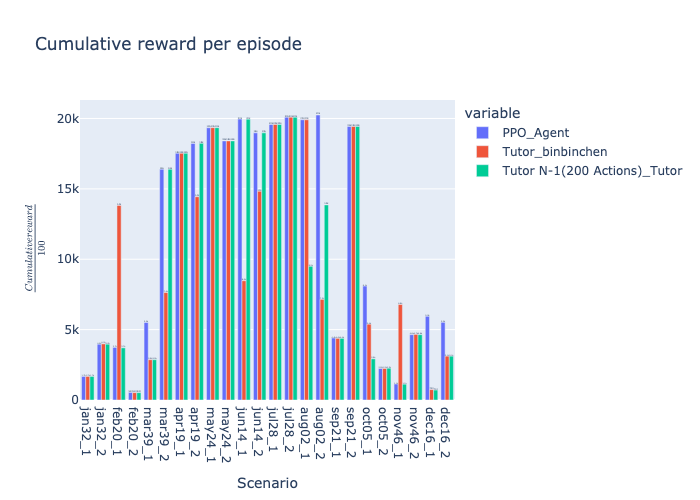

In [9]:
fig = agents.plot_cumulative_reward(agents_results)
fig.show("png")

If we are interested to compare the accomplished time steps for different agents at different scenarios, this function has the possibility to visualize them: 

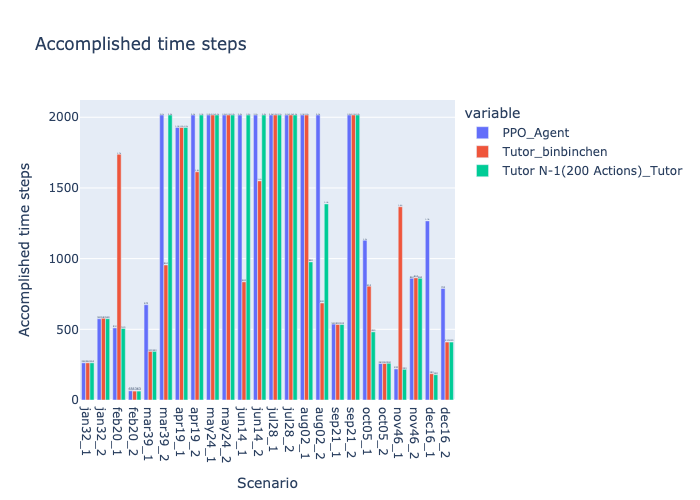

In [10]:
fig = agents.plot_cumulative_reward(agents_results, CumReward= False)
fig.show("png")

# <a class="anchor" id="actions_frequency">Actions frequency</a>
### 1. Actions frequency by type
We can visualize the frequency of different actions for each agent. In figure below we can see that in both agents below 100% of the actions are topology changes.

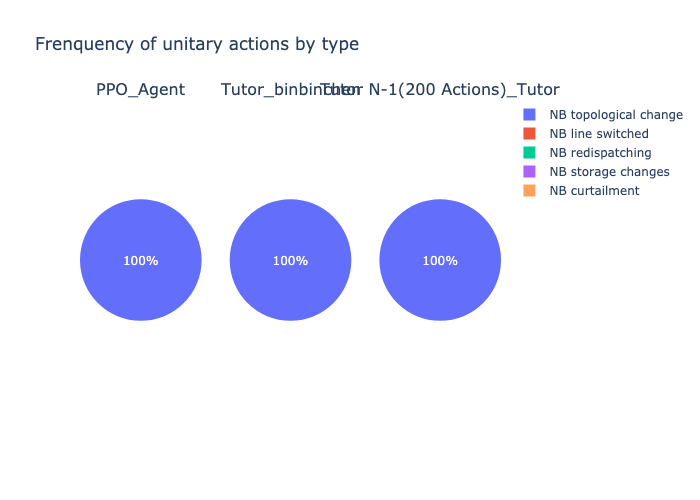

In [11]:
chart_title = "Frenquency of unitary actions by type"

fig = aa.plot_actions_freq_by_type(
    agents_results,
    col=3,
    title = chart_title)
fig.show("png")

### 2. Actions frequency by station

Sometimes the question is to see which substations are more affected by the actions. In this case, the action frequency can be visualized based on the substations, pi-chart below shows for each agent the share of each station in all the performed actions. 

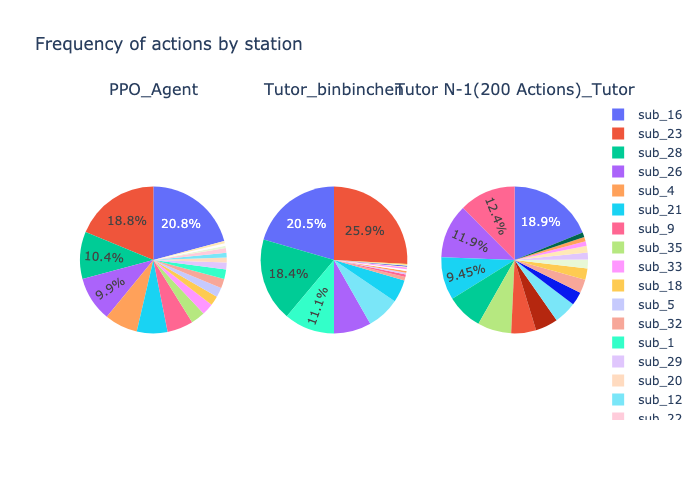

In [12]:
chart_title = "Frequency of actions by station "

fig = aa.plot_actions_freq_by_station_pie_chart(
    agents_results, 
    title = chart_title, 
    col=3)
fig.show("png")

#### Actions frequency by station : Tutor Binbinchen with actions id

Let's dig into more details about the impact stations. There are cases that we might be interested to verify which actions are mostly performed for specific substations. The two level Pychart provides this possibility to visualize the action_id for each substation. For this objective, we first need to compute the action_id using the following function: 

In [13]:
df = tutor_binbinchen.get_actions_by_substation_by_id()

Calculating actions id


24it [00:02, 11.47it/s]


In [14]:
df

,t_step,time_stamp,action_id,susbtation,episode,nb_action
0,227,2012-01-02 20:55:00,act_227,sub_16,jan32_1,1.0
1,260,2012-01-02 23:40:00,act_260,sub_28,jan32_1,1.0
2,261,2012-01-02 23:45:00,act_261,sub_16,jan32_1,1.0
3,68,2012-01-19 07:40:00,act_331,sub_16,jan32_2,1.0
4,84,2012-01-19 09:00:00,act_347,sub_23,jan32_2,1.0
...,...,...,...,...,...,...
518,175,2012-12-15 21:35:00,act_1343,sub_16,dec16_2,1.0
519,176,2012-12-15 21:40:00,act_423,sub_26,dec16_2,1.0
520,220,2012-12-16 01:20:00,act_1343,sub_16,dec16_2,1.0
521,222,2012-12-16 01:30:00,act_6592,sub_23,dec16_2,1.0


This dataframe can help to retrieve specific time steps at which a given action was used. 

Once we have the dataframe of the action_id and action frequency for each substation, we can use the dataframe to visualize for each substation, which actions and in which proportion has occurred. This visualization is presented as a two level Pychart:

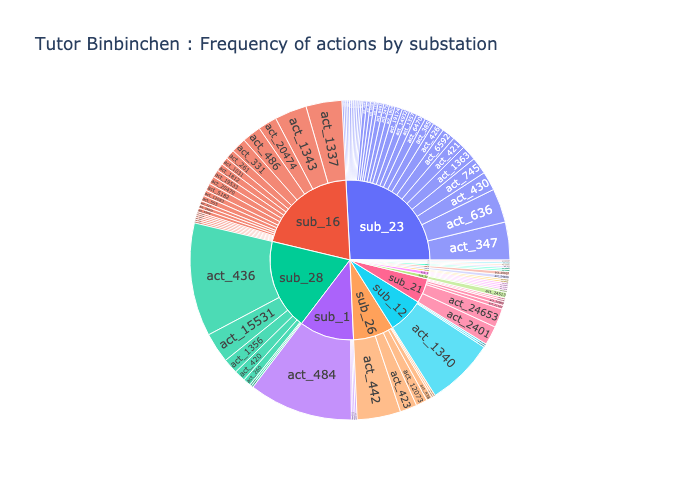

In [15]:
fig = eps.plot_actions_by_station_by_id(
    df,
    title = 'Tutor Binbinchen : Frequency of actions by substation')
fig.show("png")

If you want to go further in your analysis, you can view several information about different types of actions using the display_detailed_action_type() function. 

The widget provide the possibility to choose the action type to focus on the actions of the same type and also the columns of dataframe have the filtering possibility in case we want to check a specific substation or action_id.

These informations can be: the action id, the type, the impact on the power network and the scenario in which the action has taken place.

In [16]:
#Important remark: in order to see the dataframes produced in the next cell, you need to execuent once the two
#lines bellow and dont forget to restart your jupyter once. Then you can comment them


#jupyter nbextension enable --py --sys-prefix qgrid
#jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [17]:
tutor_binbinchen.display_detailed_action_type(agents.episodes_names)

# <a class="anchor" id="actions_impact">Impact of actions on objects</a>
### 1. Impact on lines

#### 1.1 Overloaded lines
In this section we can analyzse and visualize the impact of actions on lines. We start with overloaded lines, below the overloaded lines for different agents are visualized as barplots.

We can visualize overloaded lines and compare the results of different agents in a bar plot. This helps to figure out what might be the crirtical or weak lines on the grid for a given agent. Example below is the usage of function for overloaded lines: 

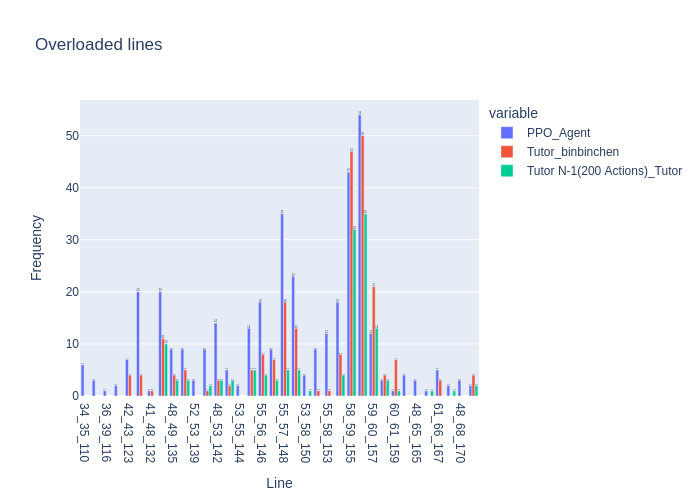

In [18]:
# if disconnected == False, then plot overloaded lines, else plot disconnected lines

chart_title = "Overloaded lines"
fig = aa.plot_lines_impact(
    agents_results,
    title= chart_title,
    yaxis_type = "linear")
fig.show("png")

#### 1.2 Disconnected lines
In the same manner, we can visualized and compare the disconnected lines.

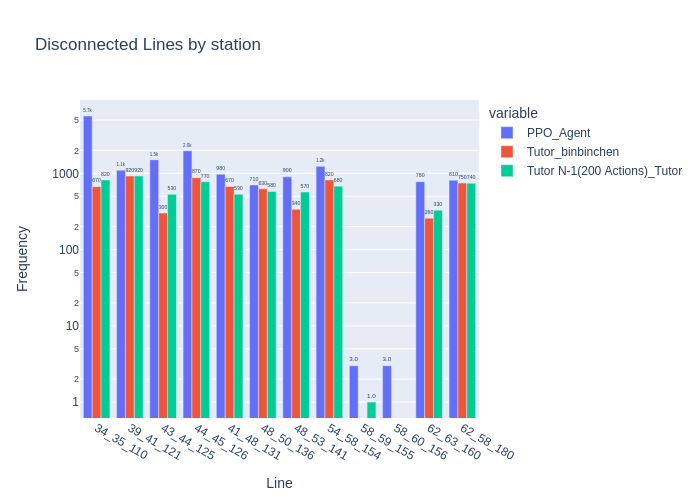

In [19]:
chart_title = "Disconnected lines"

fig = aa.plot_lines_impact(
    agents_results, 
    overloaded= False,
    title = chart_title,
)
fig.show("png")

### 2. Impact on reference topology

This indicator gives an idea if the agent is rather acting smoothly or not, how far he might get from a reference topology in a more unknown configuration, or how much time it might stay in a new configuration. The function below provides the possibility to compute and compare the distance from the initial topology at each time step for the selected episode.

In [20]:
w = widgets.Dropdown(
            options=agents.episodes_names,
            
            description='Episode',
        )
def f(x):
    fig = aa.plot_distance_from_initial_topology(agents_results, episodes_names=[x])
    display(fig.show("png"))
    
interact(f, x=w);

interactive(children=(Dropdown(description='Episode', options=('jan32_1', 'jan32_2', 'feb20_1', 'feb20_2', 'ma…

### 3. Impact on substations

In the same way as impact of actions on lines, we can visualized the impact of actions on the substations. Figure below presents the frequency of action by stations for two different agents. 
This is a different representation than the Pie chart above that allows for more quantitative comparison between agents. Figure below presents the frequency of action by stations for two different agents. 

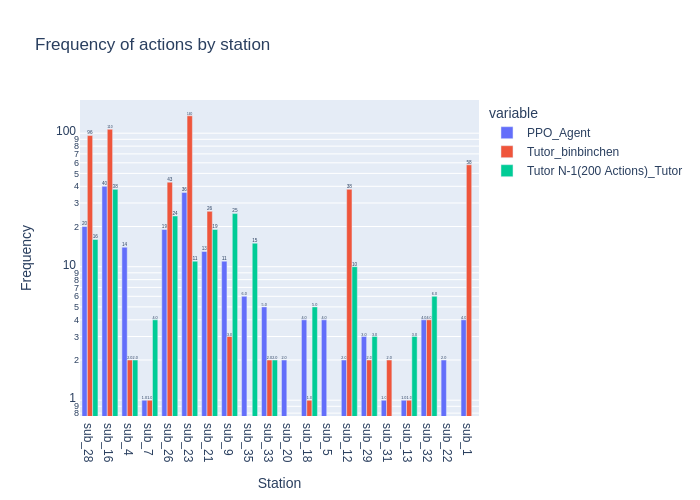

In [21]:
fig = aa.plot_actions_freq_by_station(
    agents_results,
    yaxis_type = 'log'
)
fig.show("png")

# <a class="anchor" id="execution_time">Action execution time</a>

Agent execution time can be visualized and compared for several agents. Figure below presents the execution time of two agents for the selected episode. 

In [22]:
w = widgets.Dropdown(
            options=agents.episodes_names,
            
            description='Episode',
        )
def f(x):
    fig = aa.plot_computation_times(agents_results, episodes_names=[x])
    display(fig.show("png"))
    
interact(f, x=w);

interactive(children=(Dropdown(description='Episode', options=('jan32_1', 'jan32_2', 'feb20_1', 'feb20_2', 'ma…

# <a class="anchor" id="sequence_length">Actions sequence length</a>


A longer action sequence length might indicate a more advance planning capability, or a heretic behavior for an agent. We can visualize the action sequence length with a widget to select the episode that we want to analyze:

In [23]:
min_length= 0
max_length= 15
bg = "rgba(0,0,0,0)"
    
def f(x):
    if not type(x)==list : eps = [x]
    else : eps =x
    
    fig = agents.plot_actions_sequence_length(
           agents_results,
           episodes_names=eps,
           min_length=min_length,
           max_length=max_length,
           plot_bgcolor = bg
       )

    display(fig.show("png")
           )

interact(f, x=w);

interactive(children=(Dropdown(description='Episode', options=('jan32_1', 'jan32_2', 'feb20_1', 'feb20_2', 'ma…

Let's visualize the sequence of actions as tabular data, and keep only the sequences greater than 5

In [24]:
min_length= 5
max_length= 15

tutor_binbinchen.display_sequence_actions(
    min_length=min_length,
    max_length=max_length,
)

,Timestamp,Sequence start,Sequence end,Sequence length,NB actions,NB unitary actions,Impacted Subs,Impacted lines
0,"[2012-01-19 14:55:00, 2012-01-19 15:00:00, 201...",2012-01-19 14:55:00,2012-01-19 15:20:00,6,6,18,"[[sub_16], [sub_9], [sub_28], [sub_23], [sub_1...","[[], [], [], [], [], []]"
1,"[2012-02-07 11:10:00, 2012-02-07 11:15:00, 201...",2012-02-07 11:10:00,2012-02-07 11:30:00,5,5,20,"[[sub_28], [sub_23], [sub_16], [sub_21], [sub_...","[[], [], [], [], []]"
2,"[2012-02-07 12:05:00, 2012-02-07 12:10:00, 201...",2012-02-07 12:05:00,2012-02-07 12:25:00,5,5,20,"[[sub_28], [sub_23], [sub_16], [sub_26], [sub_...","[[], [], [], [], []]"
3,"[2012-07-13 09:50:00, 2012-07-13 09:55:00, 201...",2012-07-13 09:50:00,2012-07-13 10:10:00,5,5,23,"[[sub_23], [sub_28], [sub_1], [sub_16], [sub_23]]","[[], [], [], [], []]"
4,"[2012-11-05 19:05:00, 2012-11-05 19:10:00, 201...",2012-11-05 19:05:00,2012-11-05 19:35:00,7,7,15,"[[sub_28], [sub_31], [sub_7], [sub_1], [sub_28...","[[], [], [], [], [], [], []]"
5,"[2012-11-06 10:45:00, 2012-11-06 10:50:00, 201...",2012-11-06 10:45:00,2012-11-06 11:10:00,6,6,17,"[[sub_21], [sub_16], [sub_23], [sub_26], [sub_...","[[], [], [], [], [], []]"
6,"[2012-11-08 11:25:00, 2012-11-08 11:30:00, 201...",2012-11-08 11:25:00,2012-11-08 11:50:00,6,6,29,"[[sub_28], [sub_16], [sub_21], [sub_23], [sub_...","[[], [], [], [], [], []]"
7,"[2012-12-04 21:40:00, 2012-12-04 21:45:00, 201...",2012-12-04 21:40:00,2012-12-04 22:20:00,9,9,34,"[[sub_28], [sub_32], [sub_33], [sub_29], [sub_...","[[], [], [], [], [], [], [], [], []]"
8,"[2012-12-15 21:15:00, 2012-12-15 21:20:00, 201...",2012-12-15 21:15:00,2012-12-15 21:40:00,6,6,26,"[[sub_16], [sub_26], [sub_23], [sub_21], [sub_...","[[], [], [], [], [], []]"


We can expand each row further to show detailed information about each sequence. Here we only show sequences greater than 7, you can customize this by changing the max_length and max_length parameters

In [25]:
min_length= 7
max_length= 15

tutor_binbinchen.display_sequence_actions_filter(
    min_length=min_length,
    max_length=max_length,
)

,Timestamp,NB unitary actions,Impacted subs,Impacted lines
329,2012-11-05 19:05:00,3,[sub_28],[]
330,2012-11-05 19:10:00,1,[sub_31],[]
331,2012-11-05 19:15:00,3,[sub_7],[]
332,2012-11-05 19:20:00,3,[sub_1],[]
333,2012-11-05 19:25:00,1,[sub_28],[]
334,2012-11-05 19:30:00,2,[sub_23],[]
335,2012-11-05 19:35:00,2,[sub_16],[]


,Timestamp,NB unitary actions,Impacted subs,Impacted lines
489,2012-12-04 21:40:00,1,[sub_28],[]
490,2012-12-04 21:45:00,1,[sub_32],[]
491,2012-12-04 21:50:00,3,[sub_33],[]
492,2012-12-04 21:55:00,3,[sub_29],[]
493,2012-12-04 22:00:00,7,[sub_23],[]
494,2012-12-04 22:05:00,11,[sub_16],[]
495,2012-12-04 22:10:00,2,[sub_18],[]
496,2012-12-04 22:15:00,3,[sub_33],[]
497,2012-12-04 22:20:00,3,[sub_23],[]


Moreover we can even retrieve actions of type grid2op.BaseAction for later use

In [26]:
timestamp = '2012-02-07 20:15:00'

grid2op_act = tutor_binbinchen.get_action_by_timestamp(timestamp)

In [27]:
print(grid2op_act)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element(s):
	 	 - Switch bus of line (extremity) id 18 [on substation 16]
	 	 - Switch bus of line (extremity) id 19 [on substation 16]
	 	 - Switch bus of line (origin) id 27 [on substation 16]
	 	 - Switch bus of line (origin) id 28 [on substation 16]
	 	 - Switch bus of line (origin) id 54 [on substation 16]
	 	 - Switch bus of generator id 5 [on substation 16]
	 	 - Switch bus of generator id 6 [on substation 16]
	 	 - Switch bus of generator id 7 [on substation 16]
	 	 - Switch bus of generator id 8 [on substation 16]
	 - NOT force any particular bus configuration


In [28]:
grid2op_act._check_for_ambiguity()

Similarly, we can retrieve observations of type grid2op.BaseObservation to plot them later using grid2op plotting functions

In [29]:
# getting the observation object from the grid2bench package
grid2op_obs = tutor_binbinchen.get_observation_by_timestamp(episode_name='feb20_1', timestamp_str= timestamp)

In grid2op's plotting function, we need the observation space to be predefined. We will therefore upload the environment to obtain this argument

In [30]:
import grid2op
env = grid2op.make("l2rpn_neurips_2020_track1_small")

After getting all the arguments we need, we pass them to the function. For more details on how to use this function visit the grid2op [documentation](https://grid2op.readthedocs.io/en/latest/plot.html?highlight=plot%20observation%20#plot-a-given-observation)

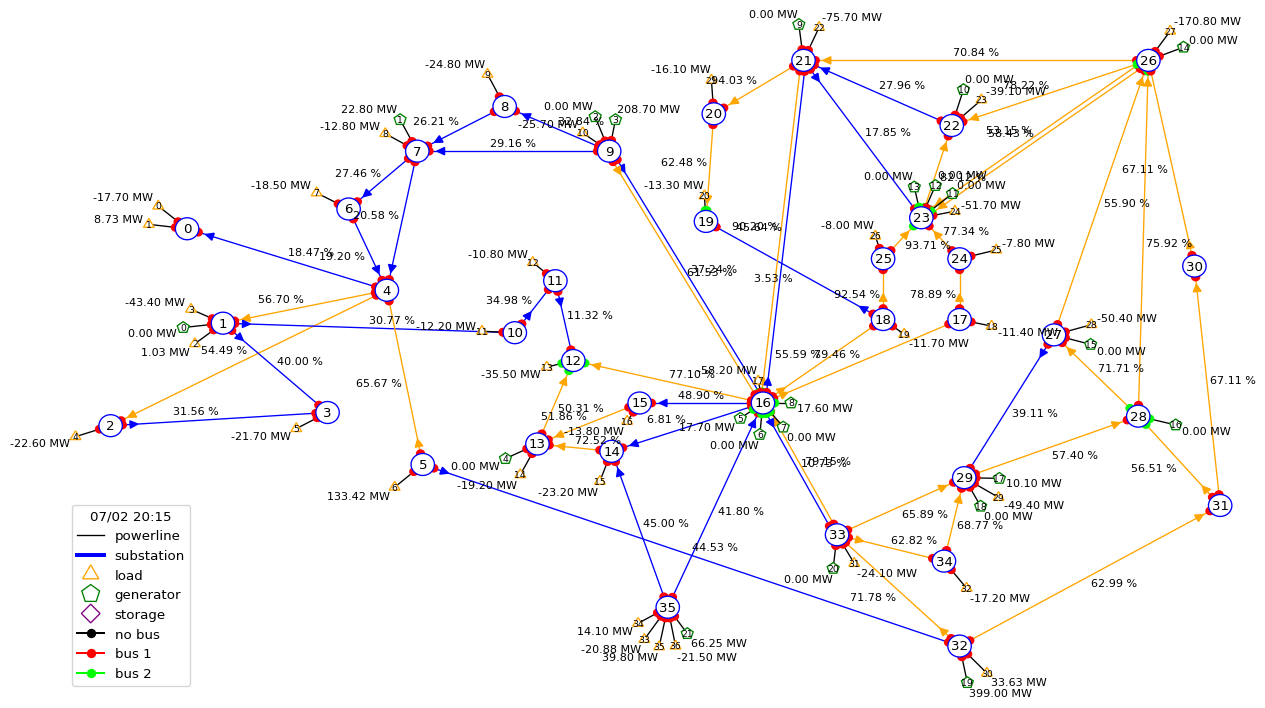

In [31]:
from grid2op.PlotGrid import PlotMatplot

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(grid2op_obs)
fig.show()

Or we can plot them using one line of code using below function

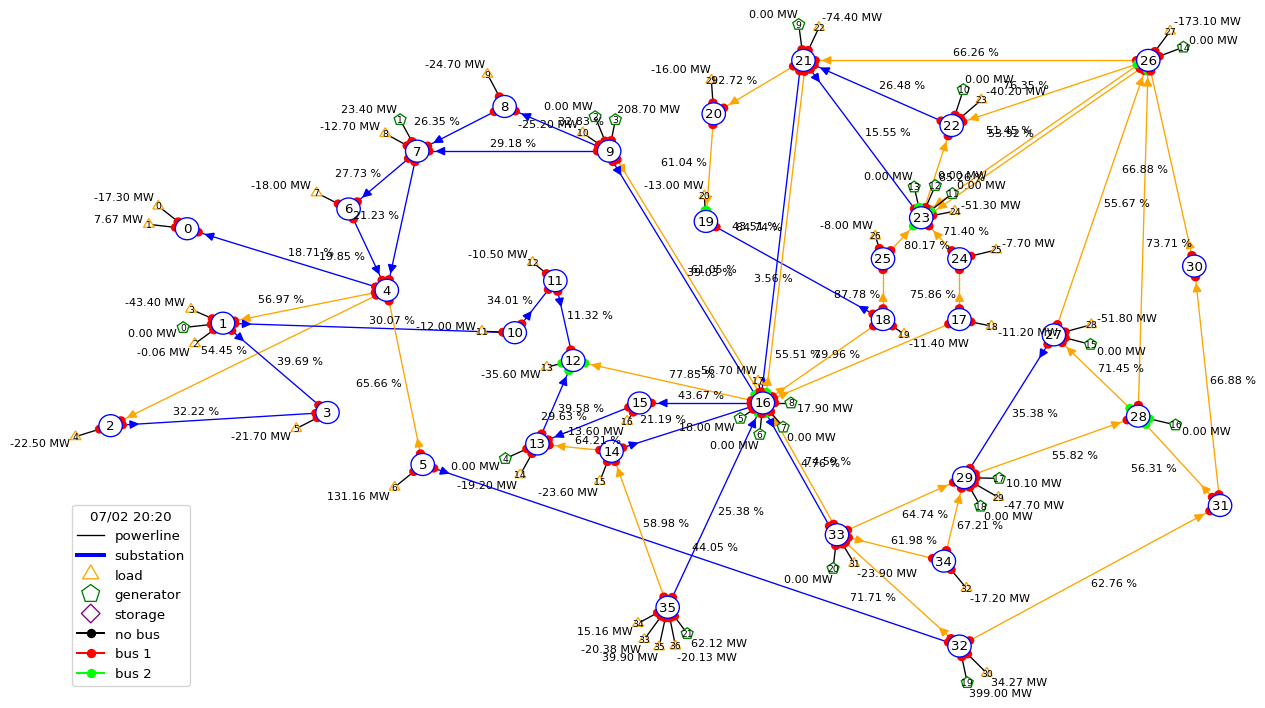

In [32]:
fig = aa.visualize_grid_state(
    env.observation_space,
    agent= tutor_binbinchen,
    episode_name="feb20_1",
    timestamp_str='2012-02-07 20:20:00')
fig.show()

### DataFrames

The first part of this notebook presents the visualization of developed KPIs using different examples. As described in the second chapter, the module EpisodeDataTransformer takes care of transforming the required data.  The output of the functions are mostly the dataframes which are served by AgentAnalytics moduel. 

In continue some examples are presented to show that these dataframes can be either separately inspected or be used for further KPI developments. 

In [33]:
ppo_agent.actions_freq_by_type_several_episodes()

,Frequency
NB line switched,0
NB topological change,644
NB redispatching,0
NB storage changes,0
NB curtailment,0


In [34]:
ppo_agent.actions_freq_by_station_several_episodes()

,Substation,Frequency
0,sub_28,20
1,sub_16,40
2,sub_4,14
3,sub_7,1
4,sub_26,19
5,sub_23,36
6,sub_21,13
7,sub_9,11
8,sub_35,6
9,sub_33,5


In [35]:
ppo_agent.disconnected_lines_freq_several_episodes()

,Line,Disconnected
0,34_35_110,5660
9,39_41_121,1101
13,43_44_125,1509
14,44_45_126,1975
18,41_48_131,975
23,48_50_136,705
27,48_53_141,900
39,54_58_154,1234
40,58_59_155,3
41,58_60_156,3


In [36]:
ppo_agent.computation_times_several_episodes()

,Timestamp,Execution time
0,2012-01-02 02:00:00,0.000535965
1,2012-01-02 02:05:00,8.39233e-05
2,2012-01-02 02:10:00,8.2016e-05
3,2012-01-02 02:15:00,6.00815e-05
4,2012-01-02 02:20:00,6.05583e-05
...,...,...
31248,2012-12-18 00:20:00,0.00264502
31249,2012-12-18 00:25:00,0.00245404
31250,2012-12-18 00:30:00,0.00271416
31251,2012-12-18 00:35:00,0.00254822


In [37]:
ppo_agent.distance_from_initial_topology()

,Timestamp,Distance
0,2012-01-02 02:00:00,0
1,2012-01-02 02:05:00,0
2,2012-01-02 02:10:00,0
3,2012-01-02 02:15:00,0
4,2012-01-02 02:20:00,0
...,...,...
31248,2012-12-18 00:20:00,0
31249,2012-12-18 00:25:00,0
31250,2012-12-18 00:30:00,0
31251,2012-12-18 00:35:00,0
